In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import os

In [476]:
path = Path(r"C:\Users\patry\Downloads\Dane_Grupa_4.zip")

dfs = {}
# Open the ZIP file
with zipfile.ZipFile(path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    file_list = file_list[1:]   
    print(f"Pliki w folderze: {file_list}")
    for txt_file in file_list:
        group_name = os.path.splitext(os.path.basename(txt_file))[0]
        print(group_name)
        with zip_ref.open(txt_file) as file:
            name = pd.read_csv(file, sep="\t")
            dfs[group_name] = name

Pliki w folderze: ['Dane_Grupa_4/Dane0001-Volt.txt', 'Dane_Grupa_4/Dane0002-Volt.txt', 'Dane_Grupa_4/Dane0003-Volt.txt', 'Dane_Grupa_4/Dane0004-Volt.txt', 'Dane_Grupa_4/Dane0005-Volt.txt', 'Dane_Grupa_4/Dane0006-Volt.txt', 'Dane_Grupa_4/Dane0007-Volt.txt']
Dane0001-Volt
Dane0002-Volt
Dane0003-Volt
Dane0004-Volt
Dane0005-Volt
Dane0006-Volt
Dane0007-Volt


In [477]:
klucz = 'Dane0005-Volt'

dfs[klucz].head()

,-4.4396,3.3684,6.8528
0,-4.4376,3.3676,6.8524
1,-4.4412,3.3660,6.8508
2,-4.4404,3.3672,6.8524
3,-4.4404,3.3668,6.8520
4,-4.4384,3.3676,6.8520


In [478]:
def volt_to_mm(df: pd.DataFrame) -> pd.DataFrame:
    """
    functions covert volt from sensor to readable mm 
    args: 
        df: dataframe with volt on all axis

    retrun
        df with 3 columns X, Y, Z
    """
    divider = 0.143 

    df_mm = pd.DataFrame({
        'X': df.iloc[:, 0] / divider,
        'Y': df.iloc[:, 1] / divider,
        'Z': df.iloc[:, 2]
    })
    
    return df_mm


In [479]:
for key, values in dfs.items():
    print(key)
    valuse = volt_to_mm(values)
    dfs[key] = valuse

Dane0001-Volt
Dane0002-Volt
Dane0003-Volt
Dane0004-Volt
Dane0005-Volt
Dane0006-Volt
Dane0007-Volt


In [480]:
dfs[klucz].head()

,X,Y,Z
0,-31.032168,23.549650,6.8524
1,-31.057343,23.538462,6.8508
2,-31.051748,23.546853,6.8524
3,-31.051748,23.544056,6.8520
4,-31.037762,23.549650,6.8520


In [481]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

def detect_low_points(data, sigma=1.0, start_percentile=0, end_percentile=15):
    """
    Detects points in the data that fall within a specified percentile range after applying a Gaussian filter.

    Args:
    - data (numpy.ndarray): Input data array.
    - sigma (float, optional): Standard deviation of the Gaussian filter. Default is 1.0.
    - start_percentile (float, optional): Lower percentile boundary. Default is 0.
    - end_percentile (float, optional): Upper percentile boundary. Default is 15.

    Returns:
    - indices_percentile (numpy.ndarray): Indices of data points falling within the specified percentile range.
    - start_percentile_val (float): Value of the lower percentile boundary.
    - end_percentile_val (float): Value of the upper percentile boundary.
    """
    # Apply Gaussian filter
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    
    # Calculate percentiles
    start_percentile_val = np.percentile(smoothed_data, start_percentile)
    end_percentile_val = np.percentile(smoothed_data, end_percentile)
    
    # Find indices within the specified percentile range
    indices_percentile = np.where((smoothed_data >= start_percentile_val) & (smoothed_data <= end_percentile_val))[0]
    
    return indices_percentile, start_percentile_val, end_percentile_val

In [482]:
import numpy as np

def split_continuous_indices(indices: np.array, lookback: int = 100, filter: int = 10) -> np.array:
    """
    Split indices into sublists of continuous values based on lookback and filter criteria.

    Args:
    - indices: NumPy array of indices to split.
    - lookback: Maximum gap size to consider indices as continuous.
    - filter: Minimum length of sublist to be considered valid.

    Returns:
    - List of NumPy arrays containing continuous sublists of indices.
    """
    if len(indices) == 0:
        return []

    sublist = []
    lists = []

    for i in range(1, len(indices)):
        if indices[i] - indices[i-1] <= lookback:
            sublist.append(indices[i])
        else:
            if len(sublist) >= filter:
                lists.append(np.array(sublist))  # Convert sublist to NumPy array before appending
            sublist = []  # Start a new sublist with the current index

    # Append the last sublist if its length is greater than or equal to filter
    if len(sublist) >= filter:
        lists.append(np.array(sublist))

    return lists


In [499]:
data = dfs[klucz]

absolute_values = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

indices_percentile, start_percentile_val, end_percentile_val = detect_low_points(absolute_values, sigma=10,
                                                                                  start_percentile=10,
                                                                                  end_percentile=35)

#indices_percentile = gaussian_filter1d(indices_percentile, sigma=0.15)

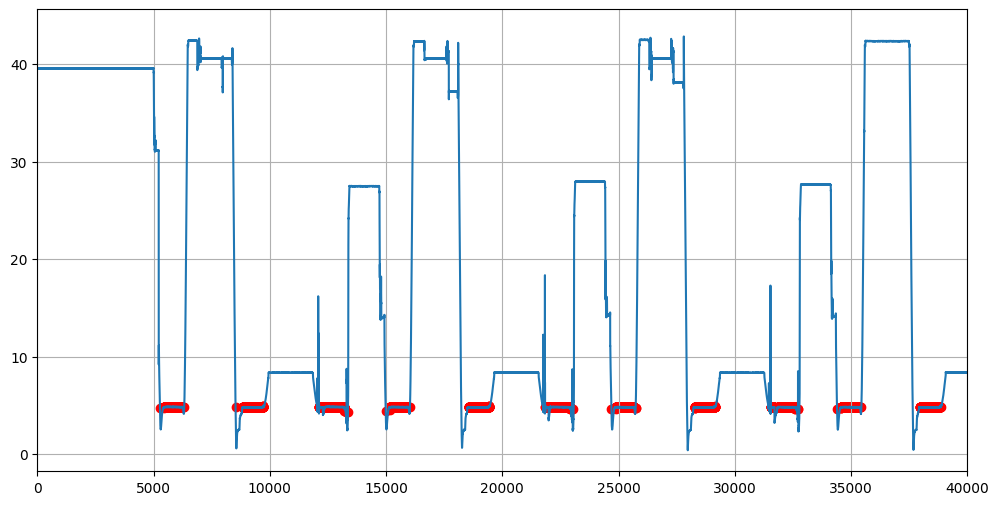

In [501]:

# Filtracja przez filtr Gaussa
smoothed_values = gaussian_filter(absolute_values[indices_percentile], sigma=3)

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(absolute_values)
plt.scatter(indices_percentile, smoothed_values, color="red")
plt.xlim(0, 40000)
plt.grid(True)
plt.show()


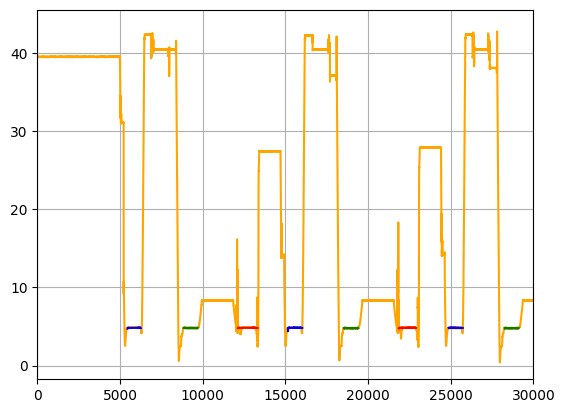

In [485]:
# Inicjowanie podziałów
sublists = split_continuous_indices(indices_percentile, lookback=1000, filter=20)

# Definicja kolorów
colors = ["blue", "green", "red"]  # Lista kolorów do cyklowania

# Inicjowanie długości podlisty
subplist_start = 0
indices_sublist = []

plt.plot(absolute_values, color="orange")

# Iteracja po podziałach
for i, sublist in enumerate(sublists):
    color = colors[i % 3]  # Cyklowanie przez kolory na podstawie i

    # Tworzenie wykresu od aktualnej długości do nowej długości podlisty
    plt.plot(sublist, smoothed_values[subplist_start : subplist_start + len(sublist)], color=color)

    indices_sublist.append(indices_percentile[subplist_start : subplist_start + len(sublist)])

    subplist_start += len(sublist)  # Aktualizacja początku kolejnej podlisty


plt.xlim(0, 30000)
plt.grid(True)
plt.show()



In [486]:
def callculate_S(data: pd.DataFrame) -> tuple:

    X = gaussian_filter(data['X'], sigma=5)
    Y = gaussian_filter(data['Y'], sigma=5)
    Z = gaussian_filter(data['Z'], sigma=5)

    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    mean_z = np.mean(Z)

    l = np.sqrt((X - mean_x)**2 + (Y - mean_y)**2 + (Z - mean_z)**2)

    unbiased_var = np.sum((l - np.mean(l))**2) / (len(l) - 1)
    std_dev = np.sqrt(unbiased_var)

    return std_dev, mean_x, mean_y, mean_z, np.mean(l)

In [487]:
def flatten_list(nested_list):
    """
    Flatten a nested list into a single list.
    
    Parameters:
    nested_list (list): The nested list to be flattened.
    
    Returns:
    list: A flattened list containing all elements from the nested list.
    """
    flattened_list = [item for sublist in nested_list for item in sublist]
    
    return flattened_list

In [488]:
# Listy do przechowywania indeksów
list_X = []
list_Y = []
list_Z = []

X = data['X']
Y = data['Y']
Z = data['Z']

# Przypisywanie indeksów do odpowiednich list
for i in range(len(indices_sublist)):
    if i % 3 == 0:
        list_X.append(indices_sublist[i])
    elif i % 3 == 1:
        list_Y.append(indices_sublist[i])
    elif i % 3 == 2:
        list_Z.append(indices_sublist[i])

In [489]:
len(flatten_list(list_X))

69604

### Calculate for X

In [490]:
data_all = data.iloc[flatten_list(list_X)]
data_first_50 = data.iloc[flatten_list(list_X[:50])]
data_last_50 = data.iloc[flatten_list(list_X)[50:]]
data_26_to_75 =data.iloc[flatten_list(list_X)[26:75]]

s_x_all, mean_xx_all, mean_xy_all, mean_xz_all, mean_lx_all = callculate_S(data_all)
s_x_first_50, mean_xx_first_50, mean_xy_first_50, mean_xz_first_50, mean_lx_first_50 = callculate_S(data_first_50)
s_x_last_50, mean_xx_last_50, mean_xy_last_50, mean_xz_last_50, mean_lx_last_50 = callculate_S(data_last_50)
s_x_26_to_75, mean_xx_26_to_75, mean_xy_26_to_75, mean_xz_26_to_75, mean_lx_26_75 = callculate_S(data_26_to_75)

### Calculate for Y

In [491]:
data_all = data.iloc[flatten_list(list_Y)]
data_first_50 = data.iloc[flatten_list(list_Y[:50])]
data_last_50 = data.iloc[flatten_list(list_Y)[50:]]
data_26_to_75 =data.iloc[flatten_list(list_Y)[26:75]]

s_y_all, mean_yx_all, mean_yy_all, mean_yz_all, mean_ly_all = callculate_S(data_all)
s_y_first_50, mean_yx_first_50, mean_yy_first_50, mean_yz_first_50, mean_ly_first_50 = callculate_S(data_first_50)
s_y_last_50, mean_yx_last_50, mean_yy_last_50, mean_yz_last_50, mean_ly_last_50  = callculate_S(data_last_50)
s_y_26_to_75, mean_yx_26_to_75, mean_yy_26_to_75, mean_yz_26_to_75, mean_ly_26_75 = callculate_S(data_26_to_75)

### Calculate for Z

In [492]:
data_all = data.iloc[flatten_list(list_Y)]
data_first_50 = data.iloc[flatten_list(list_Y[:50])]
data_last_50 = data.iloc[flatten_list(list_Y)[50:]]
data_26_to_75 =data.iloc[flatten_list(list_Y)[26:75]]

s_z_all, mean_zx_all, mean_zy_all, mean_zz_all, mean_lz_all = callculate_S(data_all)
s_z_first_50, mean_zx_first_50, mean_zy_first_50, mean_zz_first_50, mean_lz_first_50 = callculate_S(data_first_50)
s_z_last_50, mean_zx_last_50, mean_zy_last_50, mean_zz_last_50, mean_lz_last_50 = callculate_S(data_last_50)
s_z_26_to_75, mean_zx_26_to_75, mean_zy_26_to_75, mean_zz_26_to_75, mean_lz_26_75 = callculate_S(data_26_to_75)

In [493]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_sphere(r1: float, r2: float, r3: float, center1: tuple, center2: tuple, center3: tuple):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Generowanie danych dla pierwszej sfery
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x1 = center1[0] + r1 * np.outer(np.cos(u), np.sin(v))
    y1 = center1[1] + r1 * np.outer(np.sin(u), np.sin(v))
    z1 = center1[2] + r1 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x1, y1, z1, color='b', alpha=0.2)

    # Generowanie danych dla drugiej sfery
    x2 = center2[0] + r2 * np.outer(np.cos(u), np.sin(v))
    y2 = center2[1] + r2 * np.outer(np.sin(u), np.sin(v))
    z2 = center2[2] + r2 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x2, y2, z2, color='g', alpha=0.2)

    # Generowanie danych dla trzeciej sfery
    x3 = center3[0] + r3 * np.outer(np.cos(u), np.sin(v))
    y3 = center3[1] + r3 * np.outer(np.sin(u), np.sin(v))
    z3 = center3[2] + r3 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x3, y3, z3, color='r', alpha=0.2)

    # Ustawienie zakresów osi
    max_radius = max(r1, r2, r3)
    ax.set_xlim([min(center1[0], center2[0], center3[0]) - max_radius,
                 max(center1[0], center2[0], center3[0]) + max_radius])
    ax.set_ylim([min(center1[1], center2[1], center3[1]) - max_radius,
                 max(center1[1], center2[1], center3[1]) + max_radius])
    ax.set_zlim([min(center1[2], center2[2], center3[2]) - max_radius,
                 max(center1[2], center2[2], center3[2]) + max_radius])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Legenda
    ax.legend([
        plt.Rectangle((0, 0), 1, 1, fc='b', alpha=0.2),
        plt.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2),
        plt.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2)
    ], [
        f'Sfera 1 (r={r1:.2f})',
        f'Sfera 2 (r={r2:.2f})',
        f'Sfera 3 (r={r3:.2f})'
    ], loc='upper right')

    plt.show()


In [494]:
# Dla X
RP_x_all = mean_lx_all + 3 * s_x_all
RP_x_first_50 = mean_lx_first_50 + 3 * s_x_first_50
RP_x_last_50 = mean_lx_last_50 + 3 * s_x_last_50
RP_x_26_to_75 = mean_lx_26_75 + 3 * s_x_26_to_75

# Dla Y
RP_y_all = mean_ly_all + 3 * s_y_all
RP_y_first_50 = mean_ly_first_50 + 3 * s_y_first_50
RP_y_last_50 = mean_ly_last_50 + 3 * s_y_last_50
RP_y_26_to_75 = mean_ly_26_75 + 3 * s_y_26_to_75

# Dla Z
RP_z_all = mean_lz_all + 3 * s_z_all
RP_z_first_50 = mean_lz_first_50 + 3 * s_z_first_50
RP_z_last_50 = mean_lz_last_50 + 3 * s_z_last_50
RP_z_26_to_75 = mean_lz_26_75 + 3 * s_z_26_to_75


In [504]:
print(f"RP_x_first_50: {RP_x_first_50} mm")
print(f"RP_y_first_50: {RP_y_first_50} mm")
print(f"RP_z_first_50: {RP_z_first_50} mm")

RP_x_first_50: 0.17574324404750197 mm
RP_y_first_50: 0.11760360317543911 mm
RP_z_first_50: 0.11760360317543911 mm


In [505]:
print(f"RP_x_all: {RP_x_all} mm")
print(f"RP_y_all: {RP_y_all} mm")
print(f"RP_z_all: {RP_z_all} mm")

RP_x_all: 0.17889476116026082 mm
RP_y_all: 0.13060904531067982 mm
RP_z_all: 0.13060904531067982 mm


In [507]:
print(f"RP_x_last_50: {RP_x_last_50} mm")
print(f"RP_y_last_50: {RP_y_first_50} mm")
print(f"RP_z_last_50: {RP_z_last_50} mm")

RP_x_last_50: 0.17592838047029538 mm
RP_y_last_50: 0.11760360317543911 mm
RP_z_last_50: 0.1306530344699825 mm


In [508]:
print(f"RP_x_26_to_75: {RP_x_26_to_75} mm")
print(f"RP_y_26_to_75: {RP_y_26_to_75} mm")
print(f"RP_z_26_to_75: {RP_z_26_to_75} mm")


RP_x_26_to_75: 0.005343688301097037 mm
RP_y_26_to_75: 0.006956388722151159 mm
RP_z_26_to_75: 0.006956388722151159 mm


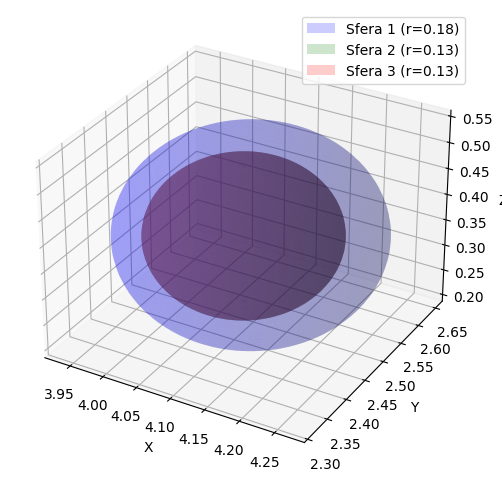

In [495]:
# Graphe for all data 
plot_3d_sphere(RP_x_all, RP_y_all, RP_z_all, 
               (mean_xx_all, mean_xy_all, mean_xz_all), 
               (mean_yx_all, mean_yy_all, mean_yz_all), 
               (mean_zx_all, mean_zy_all, mean_zz_all))

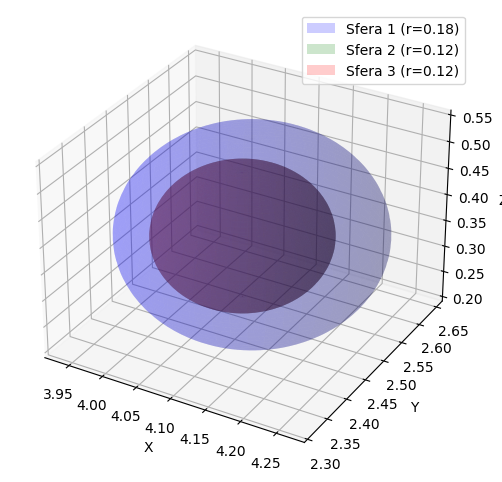

In [496]:
# Graphe for first 50
plot_3d_sphere(RP_x_first_50, RP_y_first_50, RP_z_first_50, 
               (mean_xx_first_50, mean_xy_first_50, mean_xz_first_50), 
               (mean_yx_first_50, mean_yy_first_50, mean_yz_first_50), 
               (mean_zx_first_50, mean_zy_first_50, mean_zz_first_50))

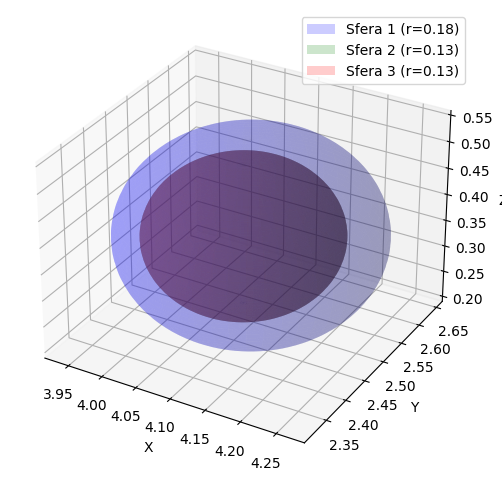

In [497]:
# Graphe for last 50
plot_3d_sphere(RP_x_last_50, RP_y_last_50, RP_y_last_50, 
               (mean_xx_last_50, mean_xy_last_50, mean_xz_last_50), 
               (mean_yx_last_50, mean_yy_last_50, mean_yz_last_50), 
               (mean_zx_last_50, mean_zy_last_50, mean_zz_last_50))

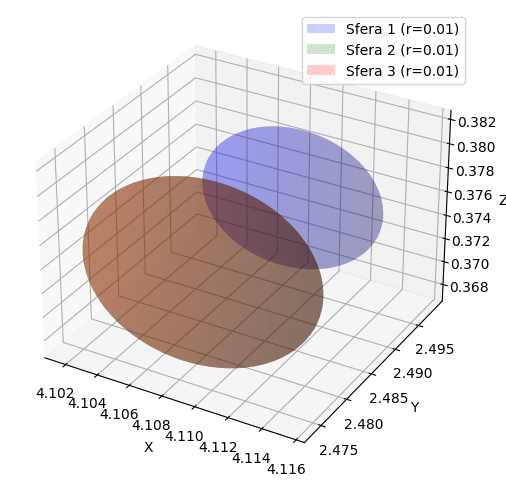

In [498]:
# Graphe for 26 to 75
plot_3d_sphere(RP_x_26_to_75, RP_y_26_to_75, RP_z_26_to_75, 
               (mean_xx_26_to_75, mean_xy_26_to_75, mean_xz_26_to_75), 
               (mean_yx_26_to_75, mean_yy_26_to_75, mean_yz_26_to_75), 
               (mean_zx_26_to_75, mean_zy_26_to_75, mean_zz_26_to_75))